In [156]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [157]:
import pandas as pd
import numpy as np

In [158]:
path='/content/drive/MyDrive/TumAI Challenge/attempt1/virtual_clinic_extract.csv'

In [159]:
virtual_clinic_extract = pd.read_csv(path)

In [160]:
virtual_clinic_extract=virtual_clinic_extract.dropna(axis=1, how='all')
virtual_clinic_extract.columns = ['case-number', 'clinic-name', 'year','age-group	','icd main-diagnosis','length of stay in days','inlier-type','admission-date','admission-time','secondary-diagnoses','procedures']
virtual_clinic_extract=virtual_clinic_extract.dropna(axis=0, how='all')
virtual_clinic_extract=virtual_clinic_extract.iloc[3:]
virtual_clinic_extract=virtual_clinic_extract.reset_index()
virtual_clinic_extract=virtual_clinic_extract.drop(columns=['index'])
virtual_clinic_extract.head()

,case-number,clinic-name,year,age-group\t,icd main-diagnosis,length of stay in days,inlier-type,admission-date,admission-time,secondary-diagnoses,procedures
0,3e7f19fe-7bad-41f2-8d3b-504d6eaf9b12,Klinik A,2018,16,I63,50,OUTLIER_LONG_STAY,2018-05-29,15:01,G81.0 | R47.1 | E11.91 | E11.90 | I11.90 | R39...,8-981.1#2018-05-29T15:01 | 1-207.0#2018-05-30T...
1,89333820-613c-474c-b129-43ffe7619175,Klinik A,2018,17,I63,"13,2",INLIER,2018-04-28,07:27,Z85.5 | R26.0 | I70.21 | H53.2 | I65.1 | G83.1...,3-220#2018-04-28T07:27 | 8-981.1#2018-04-28T07...
2,e54b0e3e-f691-4552-a17f-e6b42a7efe5b,Klinik A,2018,13,I63,"9,3",INLIER,2018-10-02,08:47,G81.0 | H34.1 | I65.2 | Z88.0 | R47.1 | I11.91,8-981.1#2018-10-02T08:47 | 3-200#2018-10-02T08...
3,52878d9b-4e1d-4f1c-9f5e-2a390f05ed39,Klinik A,2018,19,I63,"9,8",INLIER,2018-08-27,18:02,G81.0 | U50.20 | I65.2 | I11.90 | F10.1 | F10....,8-981.1#2018-08-27T18:02 | 3-200#2018-08-27T18...
4,2b07e9ed-58ac-4ab5-a9ad-f1a687ea234e,Klinik A,2018,17,I63,"12,5",INLIER,2018-10-20,22:08,G81.0 | I63.4 | I65.2 | I66.2 | U50.50 | E05.8...,3-200#2018-10-20T22:08 | 3-220#2018-10-22T08:3...


In [161]:
def f(txt):
   x=[]
   x =txt.split("| ")
   #x[2]=y
   return x

In [162]:
print(virtual_clinic_extract.shape)
#print(len(result))

(7302, 11)


In [163]:
result = [f(row) for row in virtual_clinic_extract['procedures']]

In [164]:
x=[]
relevant=[]
line=[]
for list in result:
   for row in list:
   #print(row)
       line=row.split("#")
       x.append(line)
       if '3-80' in row or '3-82' in row or '3-84' in row:
             relevant.append(line)

In [165]:
print(len(relevant))
print(len(x))

6784
88904


In [166]:
df = pd.DataFrame (relevant, columns = ['mri_type','date'])

In [167]:
def remove_time(str) :
  x=[]
  x=str.split('T')
  return x[0]


In [168]:
from datetime import datetime
df['date'] = [remove_time(row) for row in df['date']]
df['date'] = df['date'].astype('datetime64[ns]')
df1=df.copy()

In [169]:
#from datetime import datetime
#df['date'] = [datetime.strptime(row, '%Y-%m-%d') for row in df['date']]

In [170]:
lag_size = (df['date'].max().date() - df['date'].min().date()).days
print('Max date from train set: %s' % df['date'].max().date())
print('Min date from train set: %s' % df['date'].min().date())
print('Forecast lag size', lag_size)

Max date from train set: 2021-01-08
Min date from train set: 2017-11-27
Forecast lag size 1138


In [171]:
daily_mri = df.groupby('date', as_index=False).count()
daily_mri.columns = ['date', 'nb_cases']
#daily_mri['date'] = daily_mri['date'].astype('datetime64[ns]')
#daily_mri['date']  =  pd.to_datetime(daily_mri['date'], format='%Y-%m-%d')
df=daily_mri
daily_mri2=daily_mri.copy()

In [172]:
daily_mri.to_csv('daily_mri.csv')

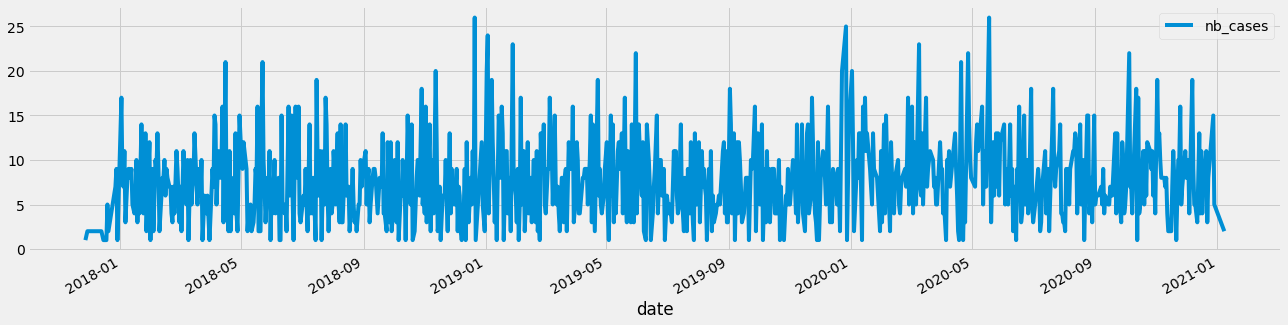

In [173]:
daily_mri.plot(x='date', y='nb_cases' ,figsize=(20,5), grid=True)

In [174]:
daily_mri=daily_mri2

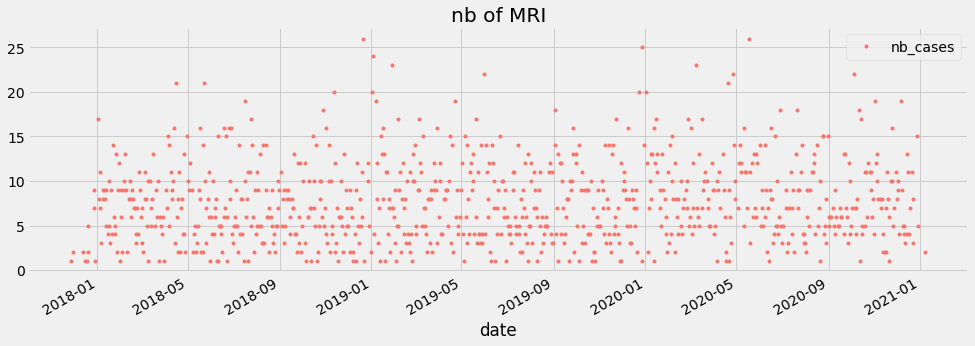

In [175]:
daily_mri =daily_mri2.set_index('date')
color_pal = ["#F8766D", "#D39200", "#93AA00", "#00BA38", "#00C19F", "#00B9E3", "#619CFF", "#DB72FB"]
_ = daily_mri.plot(style='.', figsize=(15,5), color=color_pal[0], title='nb of MRI')

In [176]:
split_date = '2020-02-01'
daily_mri_train = daily_mri.loc[daily_mri.index <= split_date].copy()
daily_mri_test = daily_mri.loc[daily_mri.index > split_date].copy()

In [177]:
daily_mri_train.shape

(638, 1)

In [178]:
daily_mri_test.shape

(247, 1)

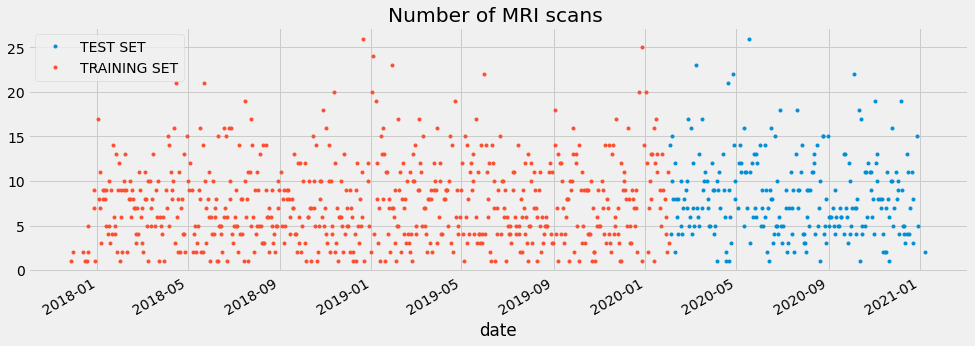

In [179]:
_ = daily_mri_test \
    .rename(columns={'nb_cases': 'TEST SET'}) \
    .join(daily_mri_train.rename(columns={'nb_cases': 'TRAINING SET'}), how='outer') \
    .plot(figsize=(15,5), title='Number of MRI scans ', style='.')

Create Time Series Features

In [180]:
def create_features(df, label=None):
    """
    Creates time series features from datetime index
    """
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    if label:
        y = df[label]
        return X, y
    return X

In [181]:
X_train, y_train = create_features(daily_mri_train, label='nb_cases')
X_test, y_test = create_features(daily_mri_test, label='nb_cases')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  del sys.path[0]


# Create XGBoost Model

In [182]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error
plt.style.use('fivethirtyeight')

In [183]:
reg = xgb.XGBRegressor(n_estimators=1000)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50,
       verbose=False) # Change verbose to True if you want to see it train

[12:57:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(n_estimators=1000)

 **Feature Importances**

 which features the model is relying on most to make the prediction. (sums up how many times each feature is split on.)

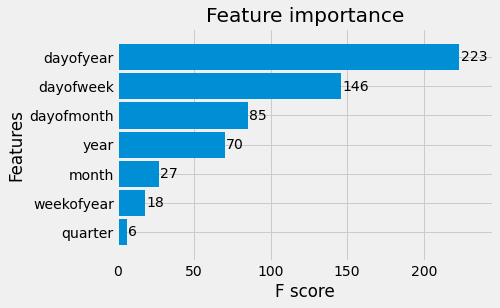

In [184]:
_ = plot_importance(reg, height=0.9)
#day of year was most commonly used to split trees

In [185]:
daily_mri_test['nb_cases_predictions'] = reg.predict(X_test)
daily_mri_all = pd.concat([daily_mri_test, daily_mri_train], sort=False)

In [186]:
#_ = daily_mri_all[['nb_cases','nb_cases_predictions']].plot(figsize=(15, 5))

In [187]:
daily_mri_test['error'] = daily_mri_test['nb_cases'] - daily_mri_test['nb_cases_predictions']
daily_mri_test['abs_error'] = daily_mri_test['error'].apply(np.abs)
error_by_day = daily_mri_test.groupby(['year','month','dayofmonth']) \
    .mean()[['nb_cases','nb_cases_predictions','error','abs_error']]

In [188]:
error_by_day.sort_values('abs_error', ascending=True).head(20)

nb_cases  nb_cases_predictions     error  abs_error
year month dayofmonth                                                     
2020 4     30               8.0              8.015116 -0.015116   0.015116
           6               10.0              9.976534  0.023466   0.023466
     2     7                8.0              7.964037  0.035963   0.035963
           14               8.0              7.964037  0.035963   0.035963
     3     25               8.0              7.962426  0.037574   0.037574
     11    27               7.0              7.055363 -0.055363   0.055363
     12    18               7.0              7.055363 -0.055363   0.055363
     6     16               8.0              8.086113 -0.086113   0.086113
     3     23              10.0              9.897930  0.102070   0.102070
     6     18               8.0              7.882815  0.117185   0.117185
     2     17              10.0              9.846851  0.153149   0.153149
     11    15               2.0              2.154506 -0.154506   0.154506
           11               8.0              7.835822  0.164178   0.164178
     2     11               8.0              8.167336 -0.167336   0.167336
           21               8.0              7.767778  0.232222   0.232222
     11    17               7.0              7.258661 -0.258661   0.258661
     10    7                7.0              7.304461 -0.304461   0.304461
     7     15               7.0              7.304461 -0.304461   0.304461
     9     16               7.0              7.304461 -0.304461   0.304461
     8     19               7.0              7.304461 -0.304461   0.304461

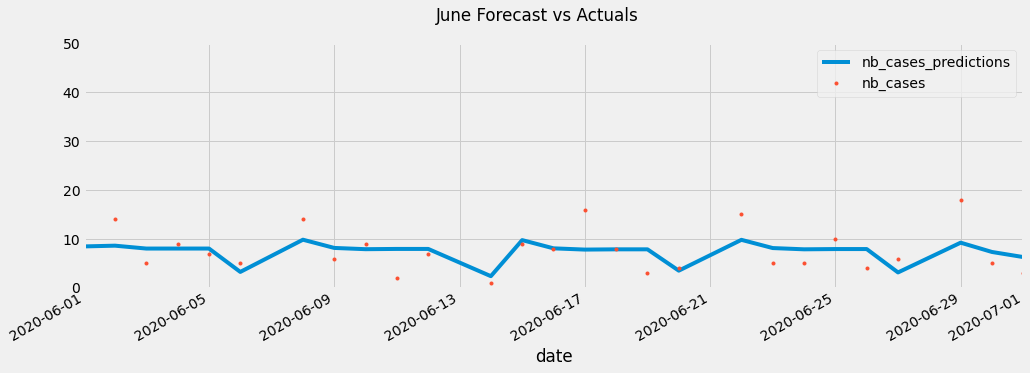

In [189]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = daily_mri_all[['nb_cases_predictions','nb_cases']].plot(ax=ax,
                                              style=['-','.'])
ax.set_xbound(lower='2020-06-01	', upper='2020-07-01	')
ax.set_ylim(0, 50)
plot = plt.suptitle('June Forecast vs Actuals')

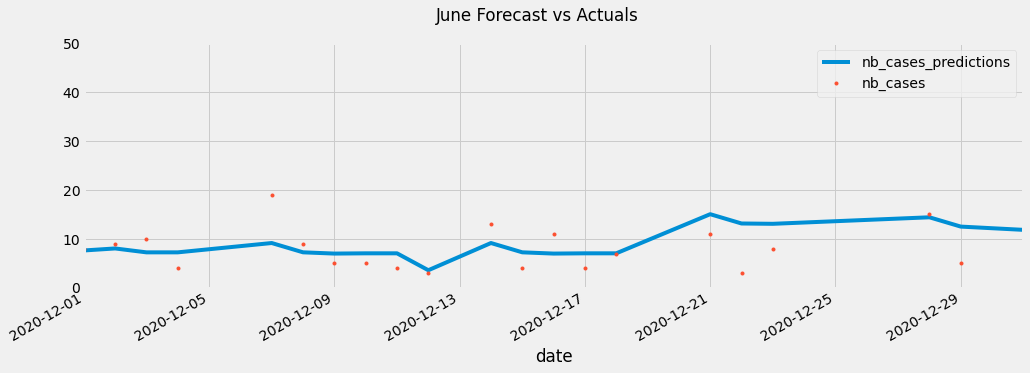

In [190]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = daily_mri_all[['nb_cases_predictions','nb_cases']].plot(ax=ax,
                                              style=['-','.'])
ax.set_xbound(lower='2020-12-01	', upper='2020-12-31	')
ax.set_ylim(0, 50)
plot = plt.suptitle('June Forecast vs Actuals')

In [191]:
mean_squared_error(y_true=daily_mri_test['nb_cases'],
                   y_pred=daily_mri_test['nb_cases_predictions'])

16.54475040645276

### **Worst predicition**

In [192]:
error_by_day.sort_values('error', ascending=True).head(2)

nb_cases  nb_cases_predictions      error  abs_error
year month dayofmonth                                                      
2020 12    22               3.0             13.148309 -10.148309  10.148309
           29               5.0             12.513908  -7.513908   7.513908

## worst day - December 29, 2020 - Christmas holiday.
Looks like our model may benefit from adding a holiday indicator.

# Facebook prophet


In [194]:
# Format data for prophet model using ds and y
df.rename(columns={'date':'ds',
                     'nb_cases':'y'})

,ds,y
0,2017-11-27,1
1,2017-11-29,2
2,2017-12-13,2
3,2017-12-15,1
4,2017-12-18,1
...,...,...
880,2020-12-22,3
881,2020-12-23,8
882,2020-12-28,15
883,2020-12-29,5


In [195]:
train =df[:650]
test=df[650:]

In [196]:
# Setup and train model and fit
from fbprophet import Prophet
model = Prophet()
model.fit(df.rename(columns={'date':'ds',
                     'nb_cases':'y'}))

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [197]:
# Predict on training set with model
predictions = model.predict(test.rename(columns={'date':'ds',
                     'nb_cases':'y'}))

In [198]:
predictions

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-02-18,6.984261,3.172116,12.985246,6.984261,6.984261,1.067948,1.067948,1.067948,1.333277,1.333277,1.333277,-0.265329,-0.265329,-0.265329,0.0,0.0,0.0,8.052209
1,2020-02-19,6.985250,3.024786,13.009865,6.985250,6.985250,0.906872,0.906872,0.906872,1.096187,1.096187,1.096187,-0.189315,-0.189315,-0.189315,0.0,0.0,0.0,7.892123
2,2020-02-20,6.986240,3.069440,12.559338,6.986240,6.986240,0.909836,0.909836,0.909836,1.016346,1.016346,1.016346,-0.106509,-0.106509,-0.106509,0.0,0.0,0.0,7.896076
3,2020-02-21,6.987230,3.686778,13.140098,6.987230,6.987230,1.109255,1.109255,1.109255,1.127781,1.127781,1.127781,-0.018526,-0.018526,-0.018526,0.0,0.0,0.0,8.096485
4,2020-02-24,6.990199,6.705362,16.815657,6.990199,6.990199,4.549352,4.549352,4.549352,4.290991,4.290991,4.290991,0.258361,0.258361,0.258361,0.0,0.0,0.0,11.539551
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
230,2020-12-22,7.289093,4.409090,14.516808,7.289093,7.289093,2.131218,2.131218,2.131218,1.333277,1.333277,1.333277,0.797941,0.797941,0.797941,0.0,0.0,0.0,9.420310
231,2020-12-23,7.290082,4.953602,14.591401,7.290082,7.290082,2.086274,2.086274,2.086274,1.096187,1.096187,1.096187,0.990086,0.990086,0.990086,0.0,0.0,0.0,9.376356
232,2020-12-28,7.295031,8.395311,18.011633,7.295031,7.295031,6.028078,6.028078,6.028078,4.290991,4.290991,4.290991,1.737087,1.737087,1.737087,0.0,0.0,0.0,13.323109
233,2020-12-29,7.296021,5.615297,14.982354,7.296021,7.296021,3.169556,3.169556,3.169556,1.333277,1.333277,1.333277,1.836279,1.836279,1.836279,0.0,0.0,0.0,10.465577


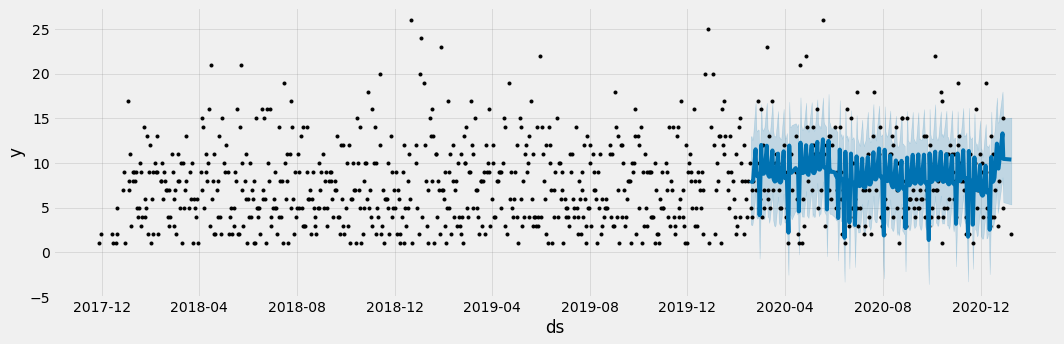

In [199]:
# Plot the forecast
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
fig = model.plot(predictions,
                 ax=ax)
plt.show()

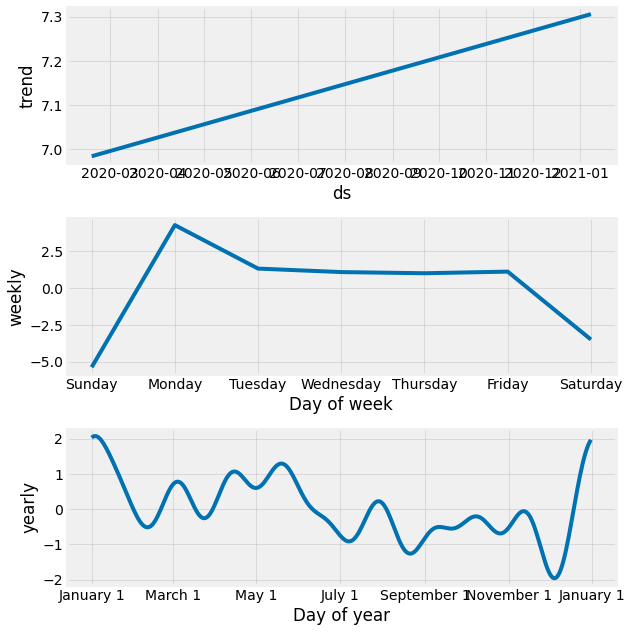

In [200]:
# Plot the components of the model
fig = model.plot_components(predictions)

In [201]:
mean_squared_error(y_true=test['nb_cases'],
                   y_pred=predictions['yhat'])

14.710837655968577

In [202]:
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mean_absolute_percentage_error(y_true=test['nb_cases'],
                   y_pred=predictions['yhat'])

59.52195182808353

**Adding Holidays**

In [203]:
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

cal = calendar()
train_holidays = cal.holidays(start=daily_mri_train.index.min(),
                              end=daily_mri_train.index.max())
test_holidays = cal.holidays(start=daily_mri_test.index.min(),
                             end=daily_mri_test.index.max())

In [204]:
daily_mri1 =daily_mri.copy()

In [205]:
# Create a dataframe with holiday, ds columns
daily_mri1['date'] = daily_mri1.index
daily_mri1['is_holiday'] = daily_mri1.date.isin([d for d in cal.holidays()])

daily_mri1

,nb_cases,date,is_holiday
date,,,
2017-11-27,1,2017-11-27,False
2017-11-29,2,2017-11-29,False
2017-12-13,2,2017-12-13,False
2017-12-15,1,2017-12-15,False
2017-12-18,1,2017-12-18,False
...,...,...,...
2020-12-22,3,2020-12-22,False
2020-12-23,8,2020-12-23,False
2020-12-28,15,2020-12-28,False


In [206]:
holiday_df = daily_mri1.loc[daily_mri1['is_holiday']] \
   
holiday_df['holiday'] = 'Holiday'
holiday_df = holiday_df.drop(['nb_cases','date','is_holiday'], axis=1)
holiday_df.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,holiday
date,
2018-01-15,Holiday
2018-02-19,Holiday
2018-05-28,Holiday
2018-07-04,Holiday
2018-09-03,Holiday


In [207]:
holiday_df['ds'] = pd.to_datetime(holiday_df.index)
holiday_df

,holiday,ds
date,,
2018-01-15,Holiday,2018-01-15
2018-02-19,Holiday,2018-02-19
2018-05-28,Holiday,2018-05-28
2018-07-04,Holiday,2018-07-04
2018-09-03,Holiday,2018-09-03
2018-10-08,Holiday,2018-10-08
2018-11-12,Holiday,2018-11-12
2018-11-22,Holiday,2018-11-22
2019-01-21,Holiday,2019-01-21


In [208]:
holiday_df=holiday_df.reset_index()
holiday_df = holiday_df.drop(['date'], axis=1)

In [209]:
# Setup and train model with holidays
model_with_holidays = Prophet(holidays=holiday_df)

model_with_holidays.fit(df.rename(columns={'date':'ds',
                     'nb_cases':'y'}))

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [210]:
# Predict on training set with model
predictions_with_hols = \
    model_with_holidays.predict(test.rename(columns={'date':'ds',
                     'nb_cases':'y'}))

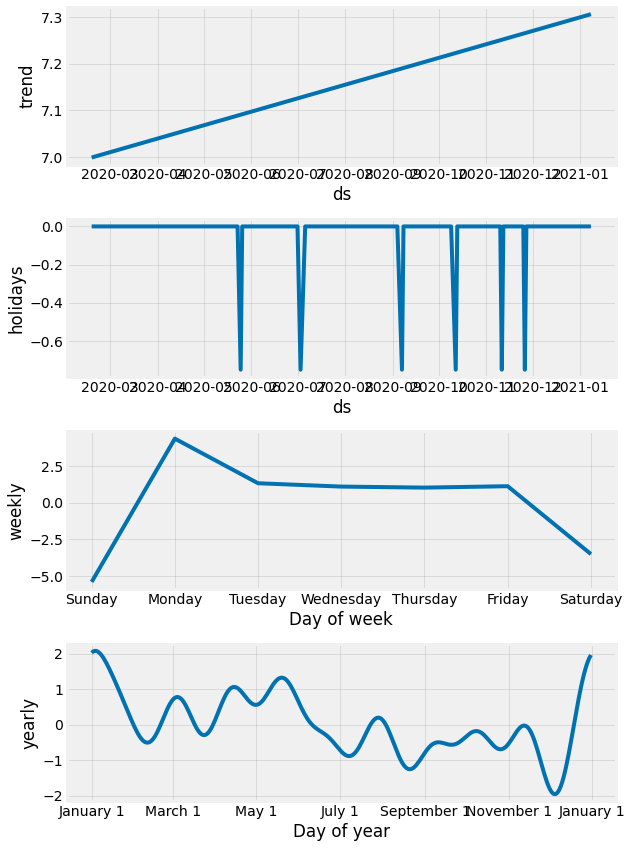

In [211]:
fig2 = model_with_holidays.plot_components(predictions_with_hols)

In [212]:
mean_squared_error(y_true=test['nb_cases'],
                   y_pred=predictions_with_hols['yhat'])

14.66508564930605

# **MRI per hospital**

In [213]:
patients_per_hospitals = virtual_clinic_extract.groupby('clinic-name', as_index=False)['case-number'].count()
patients_per_hospitals .columns = ['clinic-name', 'total MRI']

patients_per_hospitals


,clinic-name,total MRI
0,Klinik A,664
1,Klinik B,1048
2,Klinik C,431
3,Klinik D,880
4,Klinik E,929
5,Klinik F,492
6,Klinik G,2653
7,Klinik H,205


In [214]:
def g(txt,y):
   txt=y+'#'+txt
   x=[]
   x =txt.split("| ")
   #x[2]=y'
   return x

In [215]:
result_clinic= [g(row,y) for row,y in zip(virtual_clinic_extract['procedures'], virtual_clinic_extract['clinic-name'])]

In [216]:
x=[]
relevant=[]
line=[]

for list in result_clinic:
   klinik=list[0].split('#', 1)[0]
   #print(klinik)
   for row in list:
   #print(row)
       row=klinik+'#'+row
       line=row.split("#")
       x.append(line)
       if '3-80' in row or '3-82' in row or '3-84' in row:
             relevant.append(line)
 


In [217]:
mri_per_clinic = pd.DataFrame (relevant, columns = ['clinic_name','mri_type','date','none'])
mri_per_clinic=mri_per_clinic.drop(columns=['none'])

mri_per_clinic

,clinic_name,mri_type,date
0,Klinik A,3-800,2018-06-22T16:05
1,Klinik A,3-800,2018-06-25T09:27
2,Klinik A,3-821,2018-05-02T15:19
3,Klinik A,3-800,2018-05-02T15:19
4,Klinik A,3-820,2018-10-22T08:43
...,...,...,...
6779,Klinik H,3-820,2020-12-08T13:52
6780,Klinik H,3-820,2020-12-08T13:52
6781,Klinik H,3-800,2020-11-27T09:38
6782,Klinik H,3-800,2020-12-16T12:21


In [218]:
mri_per_clinic['date'] = [remove_time(row) for row in mri_per_clinic['date']]
#mri_per_clinic['date'] = mri_per_clinic['date'].astype('datetime64[ns]')
daily_mri_clinic = mri_per_clinic.groupby('clinic_name', as_index=False).count()
daily_mri_clinic.columns = ['clinic_name', 'nb_cases','g']
daily_mri_clinic=daily_mri_clinic.drop(columns=['g'])

daily_mri_clinic

,clinic_name,nb_cases
0,Klinik A,214
1,Klinik B,1382
2,Klinik C,258
3,Klinik D,651
4,Klinik E,698
5,Klinik F,243
6,Klinik G,3191
7,Klinik H,147


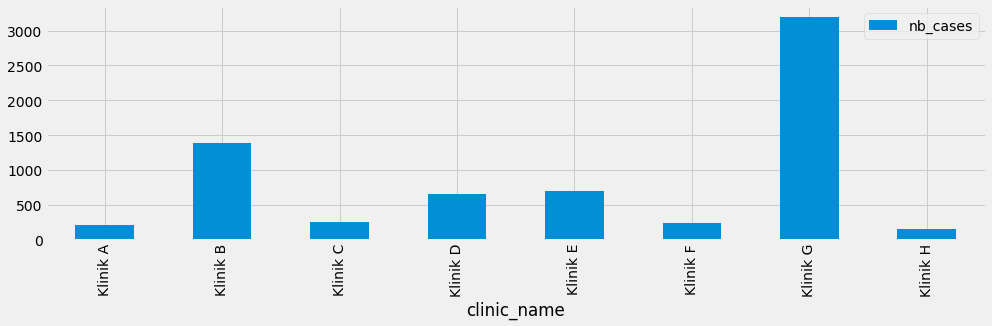

In [219]:
daily_mri_clinic.plot.bar(x='clinic_name', y='nb_cases' ,figsize=(15,4), grid=True)

In [220]:
#cleanup_nums = {"Klinik G": 7 ,"Klinik B": 6, "Klinik E": 5, "Klinik D": 4, "Klinik C": 3, "Klinik F": 2, "Klinik H": 1}
#daily_mri_clinic['clinic_name'].replace(cleanup_nums)